<a href="https://colab.research.google.com/github/Diyon335/PRA3024/blob/master/Week3_Gideon/Final_week3_fisherMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1 and 2
This section computes the standard deviation for any observables. The code is generalised as to allow the user to change their Power Spectral Density functions and Waveforms. 

In [0]:
#Import the necessary libraries 
import numpy as np
import sympy as sp

In [0]:
#Created an integration
def integral_of(function, low, high, dx):
  area = 0
  x = low
  steps = int((high-low)/dx)
  for i in range(steps):
    area += function(x)*dx
    x+=dx
  return area


In [0]:
#Declare any constants
G = 6.67*10**(-11)
c = 2.998*10**(8)
## PSD ##
#Change these variables if you change your PSD function. The following are for initial Ligo:
f0 = 150
fs = 40 
## Wavefunction h(f) ##
solar_mass = 2*(10**30)
m1 = 2*solar_mass
m2 = 1*solar_mass
M = m1 + m2
SNR = 10
eta = (m1*m2)/(M**2)
tc = 1
phic = 1

#If you want higher PN orders, then add more corrections. But dont forget to add it into the pn_array below
a0 = 1
a1 = 0
a2 = (20/9)*(743/336 + (11/4)*eta)

#The variables with which h(f) will be differentiated wrt
variables = [tc,phic,eta,M]
#change to match with variables
observables= ["tc","phic","eta","M"]

#The paper seems to use a different upper cut-off frequency, so we will use that:
#It's units are (kg)**-1. So let's put in the cs and Gs to bring it back to Hz
f_upper = ((6**(3/2)*float(sp.pi)*M)**-1) * (1/G) * c**3

In [0]:
#If any more corrections are added above, then add them to this array
pn_array = [a0,a1,a2]

In [0]:
#This is the function for the phase, xi(f)
def xi(f):
  summed_function = 0 
  v = (((float(sp.pi))*M*f)**(1/3))
  for j in range(0, len(pn_array)):
    summed_function += pn_array[j]*(v**(j))
  return 2*float(sp.pi)*f*tc - phic - float(sp.pi)/4 + (3/(128*eta*(v**5)))*summed_function

In [0]:
#Here you can initialise any PSD function
#This is for the Initial LIGO / the fs and f0 are initialised above
def s_f(f):
  S0 = 9*10**(-46)
  x = f/f0
  if f >= fs:
    return S0*((4.49*x)**(-5) + (0.16*x)**(-4.52) + 0.52 + (0.32*x)**2 )
  if f < fs:
    return 100000000000 #infinity

In [0]:
#The waveform and its conjugate
def h_real(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f,fs,f_upper,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(1j*xi_f)

def h_compl(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f,fs,f_upper,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(-1j*xi_f)

In [0]:
#This returns the derivative of the real and complex waveforms respectively 
def d_h_real(i,inc):
  return (h_real(variables[i]+inc) - h_real(variables[i])) / (inc)
def d_h_compl(j,inc):
  return (h_compl(variables[j]+inc) - h_compl(variables[j])) / (inc)

In [0]:
#Finally, this function creates the fisher matrix with a previously initialised empty nxn matrix, with a desired increment
def create_fm(matrix, increment):
  
  intg = 0
  
  for i in range(len(variables)):
    for j in range(len(variables)):
      numerator = 4 * float(sp.re(d_h_real(i, increment) * d_h_compl(j, increment)))
      intg += numerator/integral_of(s_f, fs, f_upper, increment)
      matrix[i][j] = intg
  
  return matrix

In [10]:
#Create a matrix for the values to go into
fm = np.zeros( shape=(len(variables),len(variables)) )
#Takes 5-10 seconds
create_fm(fm, 0.01)
print(fm)

[[ 1.59071799e+78  3.18143598e+78 -5.05444409e+77 -5.05444409e+77]
 [ 1.08527358e+78  2.67599158e+78 -1.01088882e+78 -1.01088882e+78]
 [-4.69776921e+78 -8.38464960e+78  7.40675943e+79  7.40675943e+79]
 [ 7.40675943e+79  7.40675943e+79  7.40675943e+79  7.40675943e+79]]


In [0]:
#This function will compute the standard deviation of measuring observables (tc, phic, eta, M)
def compute_stds(matrix):
  inverse = np.linalg.inv(matrix)
  diag_elements = []
  #appends the diagonal elements to a list
  for i in range(len(variables)):
    for j in range(len(variables)):
      if (i==j):
        diag_elements.append(inverse[i][j])
  #print(diag_elements)
  #takes the square root of each element
  for k in range(len(diag_elements)):
    diag_elements[k] = np.sqrt(diag_elements[k])

  for l in range(len(diag_elements)):
    print("The standard deviation for {} is {}".format(observables[l],diag_elements[l]))



In [14]:
compute_stds(fm)

The standard deviation for tc is 0.0
The standard deviation for phic is -0.0
The standard deviation for eta is nan
The standard deviation for M is 2.0364466357602057e-33


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


## Exercise 3
The function used to create the Fisher matrix will be modified to read PSD files. After doing so, it will be tested with a new observable, M_chirp, rather than total mass, M


In [0]:
import urllib.request as r

In [0]:
#Change these to access the files you want
name = "advancedLigo.txt"
#The arrays onto which Frequencies and Sensitivities must be loaded to to plot the graphs
x = []
y = []

#Define our new variables/Constants
M_chirp = M*eta**(3/5)
fs = 20
f0 = 215

variables = [tc,phic,eta,M_chirp]

observables= ["tc","phic","eta","M_chirp"]

In [0]:
#Define our new PSD for the advanced LIGO
def s_f_aLigo(f):
  S0 = 10**(-49)
  x = f/f0
  if f >= fs:
    return S0*(x**(-4.14) - 5*x**(-2) + (111*(1 - x**2 - (x**4) / 2))/(1 + (x**2) / 2))
  if f < fs:
    return 100000000000 #infinity

In [0]:
#The waveform and its conjugate
#Every time you define a new wave function, be sure to change it in the waveform as well
def h_real(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f_aLigo,fs,f0,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(1j*xi_f)

def h_compl(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f_aLigo,fs,f0,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(-1j*xi_f)

In [0]:
#This function opens the file you want and returns two arrays of values: the frequencies and their respective sensitvities 
def loaddata(name, x, y):
  try:
    f = open(name,"r")
    #gets how many columns there are
    firstline = f.readline()
    columns = len(firstline.split())
    #to re-read
    f.seek(0)
    #gets values from the first and last column
    lines = f.readlines()
    for l in lines:
      x.append(l.split()[0])
      y.append(l.split()[columns - 1])
    
    f.close()
    
  except:
    print("Please place the file you want to read in your directory!")

In [0]:
#We have to modify our previous function to create a Fisher Matrix
def create_fm_new(matrix, increment, name = False):
  
  intg = 0
  #This is the old function
  if(name==False):
    for i in range(len(variables)):
      for j in range(len(variables)):
        numerator = 4 * float(sp.re(d_h_real(i, increment) * d_h_compl(j, increment)))
        intg += numerator/integral_of(s_f, fs, f_upper, increment)
        matrix[i][j] = intg
  #but now if you have the name of a txt file, this will run
  elif(name!=False):
    freqs = []
    sens = []
    loaddata(name, freqs, sens)
    s = 0
    for a in range(len(variables)):
      for b in range(len(variables)):
        for f in range(len(sens)):
          s += float(sens[f])  
        numerator = 4 * float(sp.re(d_h_real(a, increment) * d_h_compl(b, increment)))
        intg += (numerator/s)*increment
        matrix[a][b] = intg
        s=0

  return matrix

In [24]:
#Create a new matrix 
#Double check if your .txt file is in your directory!
new_fm = np.zeros(shape=(len(variables),len(variables)))

create_fm_new(new_fm, 0.01,name = name)

array([[ 2.21220658e+63,  4.42441317e+63, -7.02919974e+62,
        -7.02919974e+62],
       [ 1.50928661e+63,  3.72149320e+63, -1.40583995e+63,
        -1.40583995e+63],
       [-6.53317309e+63, -1.16605062e+64,  1.03005574e+65,
         1.03005574e+65],
       [ 1.03005574e+65,  1.03005574e+65,  1.03005574e+65,
         1.03005574e+65]])

In [25]:
compute_stds(new_fm)

The standard deviation for tc is 0.0
The standard deviation for phic is -0.0
The standard deviation for eta is 3.119184002448439e-33
The standard deviation for M_chirp is 9.663577267152731e-26


## Plotting data

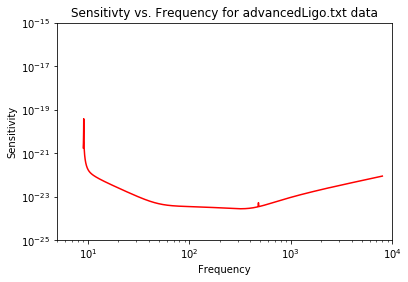

In [26]:
#Now to plot the freqs of the advanced Ligo data against the sensitivities 
import matplotlib.pyplot as plt

x_axis = []
y_axis = []

loaddata(name, x_axis,y_axis )
#print(x_axis)
#print(y_axis)
for i in range(len(x_axis)):
  x_axis[i] = float(x_axis[i])
  y_axis[i] = float(y_axis[i])


plt.figure()
plt.title("Sensitivty vs. Frequency for {} data".format(name))
plt.xlabel("Frequency")
plt.ylabel("Sensitivity")
plt.xscale("log")
plt.yscale("log")
axes = plt.gca()
axes.set_xlim(5, 10**4)
axes.set_ylim(10**(-25), 10**(-15))

plt.plot(x_axis,y_axis,color = 'r', linestyle = '-')
plt.show()


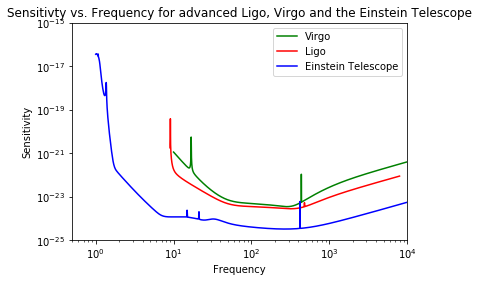

In [27]:
#Now to compare the graphs for advanced Ligo, Virgo and Einstein

new_x = []
new_y = []
e_x = []
e_y = []

loaddata("advancedVirgo.txt", new_x,new_y )
loaddata("einstein.txt", e_x,e_y)
#print(e_x)
#print(e_y)

for i in range(len(new_x)):
  new_x[i] = float(new_x[i])
  new_y[i] = float(new_y[i])

for m in range(len(e_x)):
  e_x[m] = float(e_x[m])
  e_y[m] = float(e_y[m])

plt.figure()
plt.title("Sensitivty vs. Frequency for advanced Ligo, Virgo and the Einstein Telescope")
plt.xlabel("Frequency")
plt.ylabel("Sensitivity")
plt.xscale("log")
plt.yscale("log")
axes = plt.gca()
axes.set_xlim(0.5, 10**4)
axes.set_ylim(10**(-25), 10**(-15))

plt.plot(new_x,new_y,color='g',linestyle='-',label='Virgo')
plt.plot(x_axis,y_axis,color = 'r', linestyle = '-',label='Ligo')
plt.plot(e_x,e_y,color='b',linestyle='-',label="Einstein Telescope")
plt.legend()
plt.show()

In [0]:
#Finally, here is a general function to plot any graph and compare them
def plot(files, colors, labels, log=True, linestyle = '-', xlabel = "Frequency" , ylabel = "Sensitivity"):

  plt.figure()

  for file in range(len(files)):
    x= []
    y= []
    
    loaddata(files[file], x, y)
    #converts all the indexes to floats
    for string in range(len(x)):
      x[string] = float(x[string])
      y[string] = float(y[string])

    plt.plot(x,y, color = colors[file], label = labels[file], linestyle = linestyle)

    if(log==True):
        plt.xscale('log')
        plt.yscale('log')

    axes = plt.gca()
    axes.set_xlim(0.5, 10**4)
    axes.set_ylim(10**(-25), 10**(-15))      
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title("Sensitivity vs. Frequencies of {}".format(labels))
  plt.legend()
  plt.show()
      

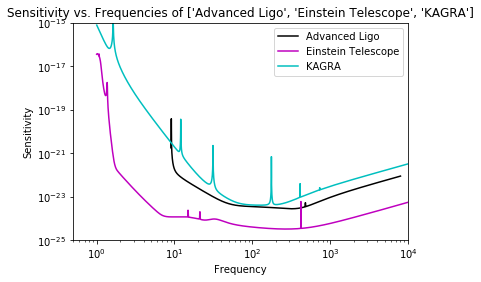

In [29]:
#Order the files, colors and labels in order!!
files = ["advancedLigo.txt","einstein.txt","kagra.txt"]
colors = ['k','m','c']
labels = ["Advanced Ligo","Einstein Telescope","KAGRA"]

plot(files, colors, labels, log=True,linestyle = '-')